In [2]:
import misleep
from itertools import groupby
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

e:\workplace\scripts\signal_process


In [53]:
data = misleep.load_mat(r'\\172.16.41.188\liyating\Data\FP\20240520_test\5HT_3h\SER_Zscore.mat')
anno = misleep.load_misleep_anno(r'\\172.16.41.188\liyating\Data\FP\20240520_test\5HT_3h\SER.txt')
start_end_anno = anno.start_end

# Define a time range for consideration, 
# means every state's duration must be greater than the time
consider_time = 5
plot_save_time = 300
consider_channel = 'Zscore'
save_csv_path = r'\\172.16.41.188\liyating\Data\FP\20240520_test\5HT_3h'
save_fig_path = r'\\172.16.41.188\liyating\Data\FP\20240520_test\5HT_3h\SER.pdf'

In [4]:
start_end_anno

[[0.003, 34.669, 'NREM'],
 [34.669, 42.075, 'Wake'],
 [42.075, 129.749, 'NREM'],
 [129.749, 135.156, 'Wake'],
 [135.156, 160.001, 'NREM'],
 [160.001, 255.807, 'REM'],
 [255.807, 288.525, 'Wake'],
 [288.525, 399.631, 'NREM'],
 [399.631, 403.748, 'Wake'],
 [403.748, 548.757, 'NREM'],
 [548.757, 556.281, 'Wake'],
 [556.281, 651.038, 'NREM'],
 [651.038, 695.569, 'REM'],
 [695.569, 703.12, 'Wake'],
 [703.12, 711.548, 'NREM'],
 [711.548, 715.221, 'Wake'],
 [715.221, 737.578, 'NREM'],
 [737.578, 767.312, 'Wake']]

In [54]:
# find transition time point
transition_points = []

for idx, state in enumerate(start_end_anno[:-1]):
    next_state = start_end_anno[idx+1]
    # If the previous state and later state have overlap in a second, 
    # make it as a transition time point, 
    # the time point is average of the first state's end and next state's start
    if abs(state[1] - next_state[0]) <= 1:
        # The two states' time must larger than 5 seconds
        if state[1] - state[0] >= consider_time and next_state[1] - next_state[0] > consider_time:
            transition_points.append(
                [f'{state[2]}_{next_state[2]}', state[0], round((state[1] + next_state[0])/2, 3), next_state[1]]
            )

In [16]:
transition_points

[['NREM_Wake', 0.012, 44.206, 113.725],
 ['Wake_NREM', 44.206, 113.725, 160.621],
 ['NREM_Wake', 164.903, 185.105, 190.599],
 ['Wake_NREM', 185.105, 190.599, 239.736],
 ['NREM_Wake', 190.599, 239.736, 250.819],
 ['Wake_NREM', 239.736, 250.819, 271.283],
 ['NREM_Wake', 250.819, 271.283, 277.053],
 ['Wake_NREM', 271.283, 277.053, 303.986],
 ['NREM_Wake', 277.053, 303.986, 355.765],
 ['Wake_NREM', 303.986, 355.765, 434.755],
 ['NREM_Wake', 355.765, 434.755, 440.45],
 ['Wake_NREM', 434.755, 440.45, 474.625],
 ['NREM_Wake', 440.45, 474.625, 495.869],
 ['Wake_NREM', 474.625, 495.869, 623.931],
 ['NREM_Wake', 495.869, 623.931, 634.296],
 ['Wake_NREM', 623.931, 634.296, 649.866],
 ['NREM_Wake', 634.296, 649.866, 801.304],
 ['Wake_NREM', 649.866, 801.304, 825.734],
 ['NREM_Wake', 801.304, 825.734, 831.628],
 ['Wake_NREM', 825.734, 831.628, 977.972],
 ['NREM_REM', 831.628, 977.972, 1128.821],
 ['REM_Wake', 977.972, 1128.821, 1156.928],
 ['Wake_NREM', 1128.821, 1156.928, 1325.609],
 ['NREM_Wake',

In [55]:
_sorted = sorted(transition_points, key=lambda x: x[0])
transition_points_group = [list(each) for _, each in groupby(_sorted, lambda x: x[0])]

In [42]:
transition_points_group

[[['NREM_NREM', 2181.264, 2191.299, 2240.959]],
 [['NREM_REM', 831.628, 977.972, 1128.821],
  ['NREM_REM', 3391.864, 3498.377, 3535.929],
  ['NREM_REM', 4473.472, 4520.425, 4615.929],
  ['NREM_REM', 4725.899, 4895.03, 4968.302],
  ['NREM_REM', 5251.129, 5326.174, 5341.444],
  ['NREM_REM', 5354.791, 5534.986, 5552.663],
  ['NREM_REM', 5681.728, 5816.174, 5893.067],
  ['NREM_REM', 7387.582, 7495.03, 7553.331],
  ['NREM_REM', 8129.98, 8179.541, 8225.01],
  ['NREM_REM', 8259.985, 8381.594, 8402.682],
  ['NREM_REM', 8424.351, 8523.456, 8552.937],
  ['NREM_REM', 8697.233, 8773.427, 8779.97],
  ['NREM_REM', 8807.293, 8840.08, 8862.168],
  ['NREM_REM', 8872.477, 8929.955, 8938.921],
  ['NREM_REM', 8957.627, 8990.155, 9150.81],
  ['NREM_REM', 9689.955, 9733.756, 9768.381],
  ['NREM_REM', 9782.023, 9810.33, 9860.04],
  ['NREM_REM', 9864.281, 10006.179, 10058.012]],
 [['NREM_Wake', 0.012, 44.206, 113.725],
  ['NREM_Wake', 164.903, 185.105, 190.599],
  ['NREM_Wake', 190.599, 239.736, 250.819],
  [

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22532\211292967.py:49: RuntimeWarning: Mean of empty slice
  _mean_group_data = np.nanmean(nan_temp_lst, axis=0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22532\211292967.py:49: RuntimeWarning: Mean of empty slice
  _mean_group_data = np.nanmean(nan_temp_lst, axis=0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22532\211292967.py:49: RuntimeWarning: Mean of empty slice
  _mean_group_data = np.nanmean(nan_temp_lst, axis=0)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22532\211292967.py:49: RuntimeWarning: Mean of empty slice
  _mean_group_data = np.nanmean(nan_temp_lst, axis=0)


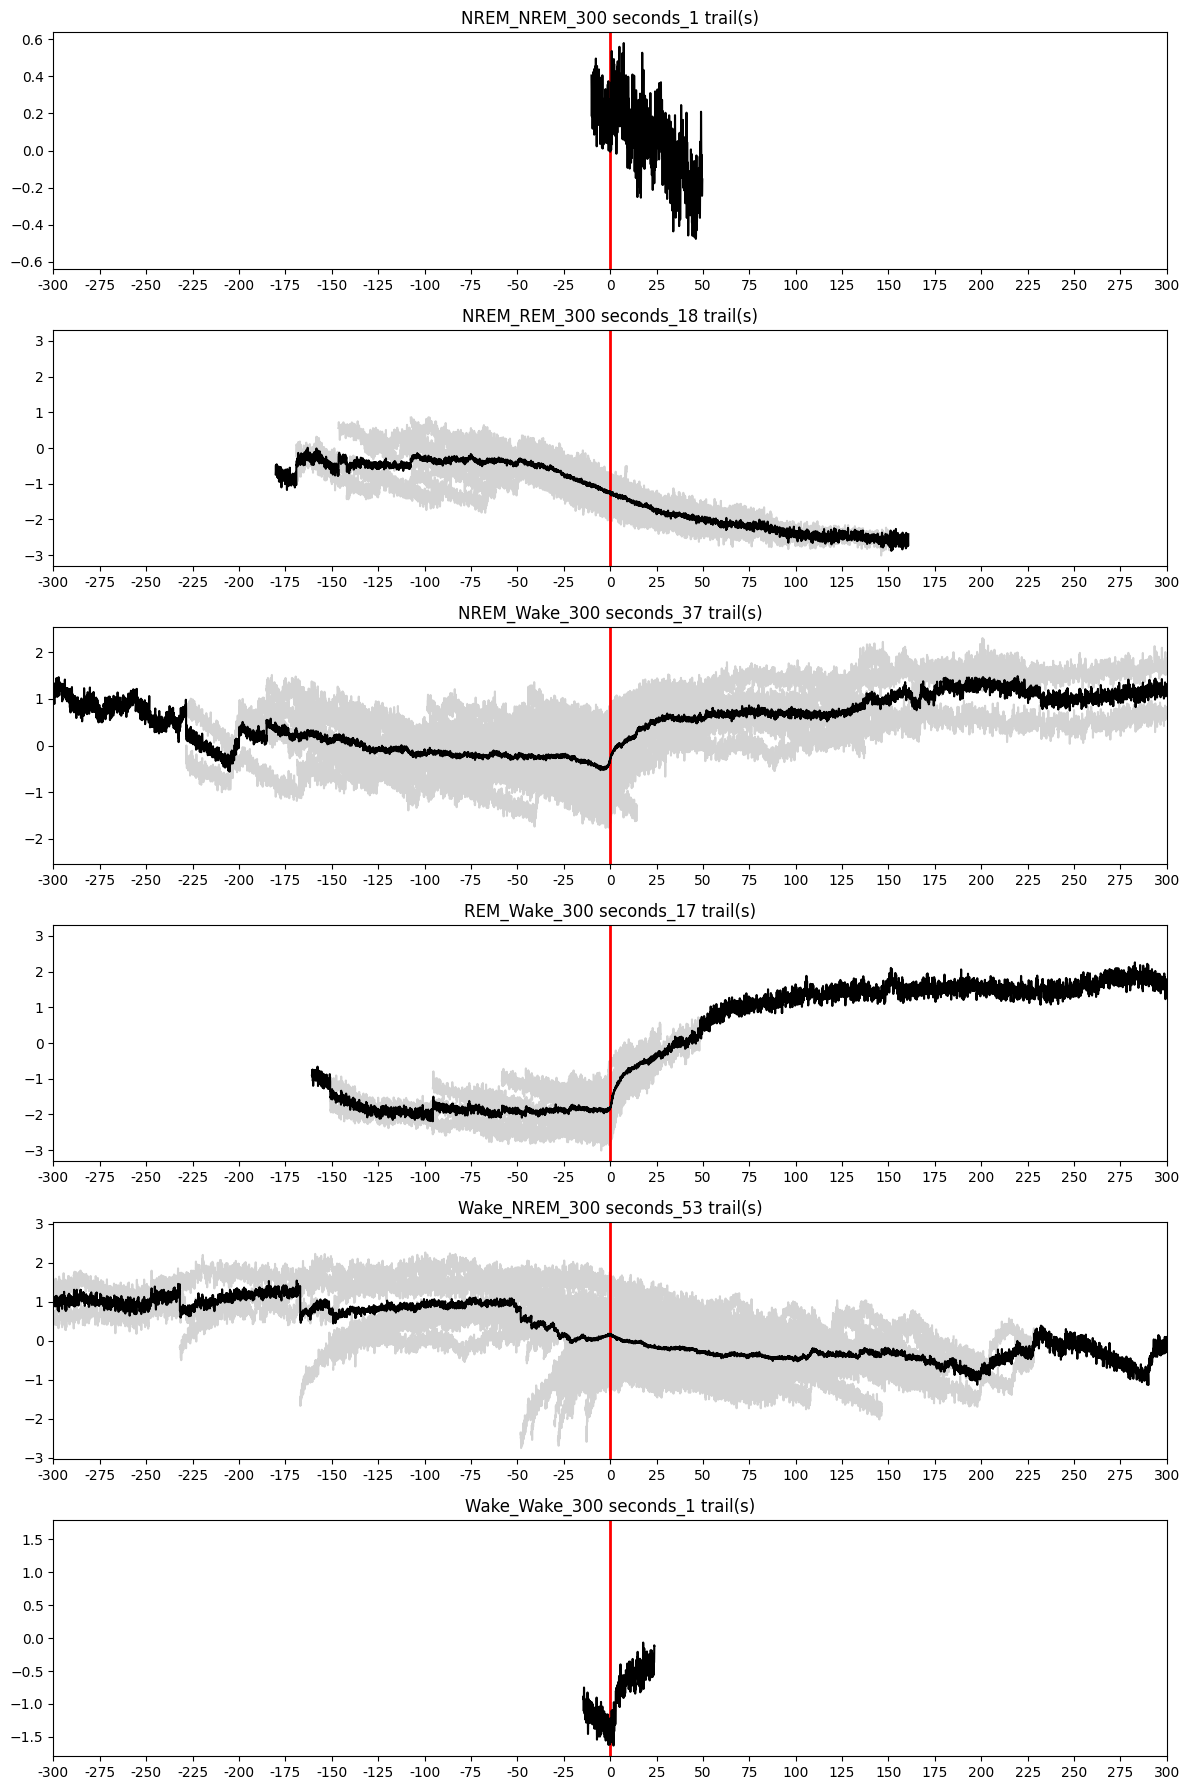

In [59]:
# Get data based on each group of transition time points
channel_midata = data.pick_chs(ch_names=[consider_channel])
channel_data = channel_midata.signals[0]
sf = channel_midata.sf[0]

# Draw
signal_figure = plt.figure(figsize=(12, 3*len(transition_points_group)))
signal_ax = signal_figure.subplots(nrows=len(transition_points_group))
signal_figure.set_tight_layout(True)

group_data = {}
for idx, transition_points in enumerate(transition_points_group):
    _name = transition_points[0][0]
    previous_max_length = max([int(each[2]*sf)-int(each[1]*sf) for each in transition_points])
    previous_max_length = max([previous_max_length, int(plot_save_time*sf)])
    later_max_length = max([int(each[3]*sf)-int(each[2]*sf)for each in transition_points])
    later_max_length = max([later_max_length, int(plot_save_time*sf)])
    _name = f'{_name}_{plot_save_time} seconds'
    _temp_lst = []
    for each in transition_points:
        previous_data = channel_data[int(each[1]*sf): int(each[2]*sf)]
        previous_data_padded = np.pad(previous_data, (previous_max_length - len(previous_data), 0), 'constant', constant_values=np.nan)
        later_data = channel_data[int(each[2]*sf): int(each[3]*sf)]
        later_data_padded = np.pad(later_data, (0, later_max_length - len(later_data)), 'constant', constant_values=np.nan)
        _temp_lst.append(np.concatenate(
            [previous_data_padded, later_data_padded]
            )[previous_max_length-int(plot_save_time*sf): 
              previous_max_length+int(plot_save_time*sf)])

    nan_temp_lst = np.array(_temp_lst)
    zero_temp_lst = np.nan_to_num(nan_temp_lst)

    pd.DataFrame(data=np.array(zero_temp_lst).T,
        columns=['->'.join([str(_) for _ in each[1:]]) for each in transition_points]
        ).to_csv(f'{save_csv_path}\{_name}.csv', index=False)

    [signal_ax[idx].plot(each, color='lightgray') for each in nan_temp_lst]
    signal_ax[idx].axvline(int(plot_save_time*sf), color='red', linewidth=2)
    signal_ax[idx].set_xlim(0, int(2*plot_save_time*sf))
    _max = np.max(np.abs(zero_temp_lst))*1.1
    signal_ax[idx].set_ylim(-_max, _max)
    signal_ax[idx].set_title(f'{_name}_{len(transition_points)} trail(s)')
    signal_ax[idx].xaxis.set_ticks(
        [int(each * sf) for each in range(0, 2*plot_save_time+1, int(5*plot_save_time/60))],
        np.arange(-plot_save_time, plot_save_time+1, int(5*plot_save_time/60)),
    )

    # calculate mean line
    try:
        _mean_group_data = np.nanmean(nan_temp_lst, axis=0)
    except RuntimeWarning:
        pass
    signal_ax[idx].plot(_mean_group_data, color='black')

    # signal_ax[idx].xaxis.set_ticks(
    #     [int(each * sf) for each in range(0, previous_max_length+later_max_length+1, 5)],
    #     np.arange(-previous_max_length, later_max_length+1, 5),
    # )

signal_figure.savefig(f'{save_fig_path[:-4]}_{plot_save_time}.pdf', dpi=300)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22532\121478342.py:40: RuntimeWarning: Mean of empty slice
  _mean_group_data = np.nanmean(nan_temp_lst, axis=0)


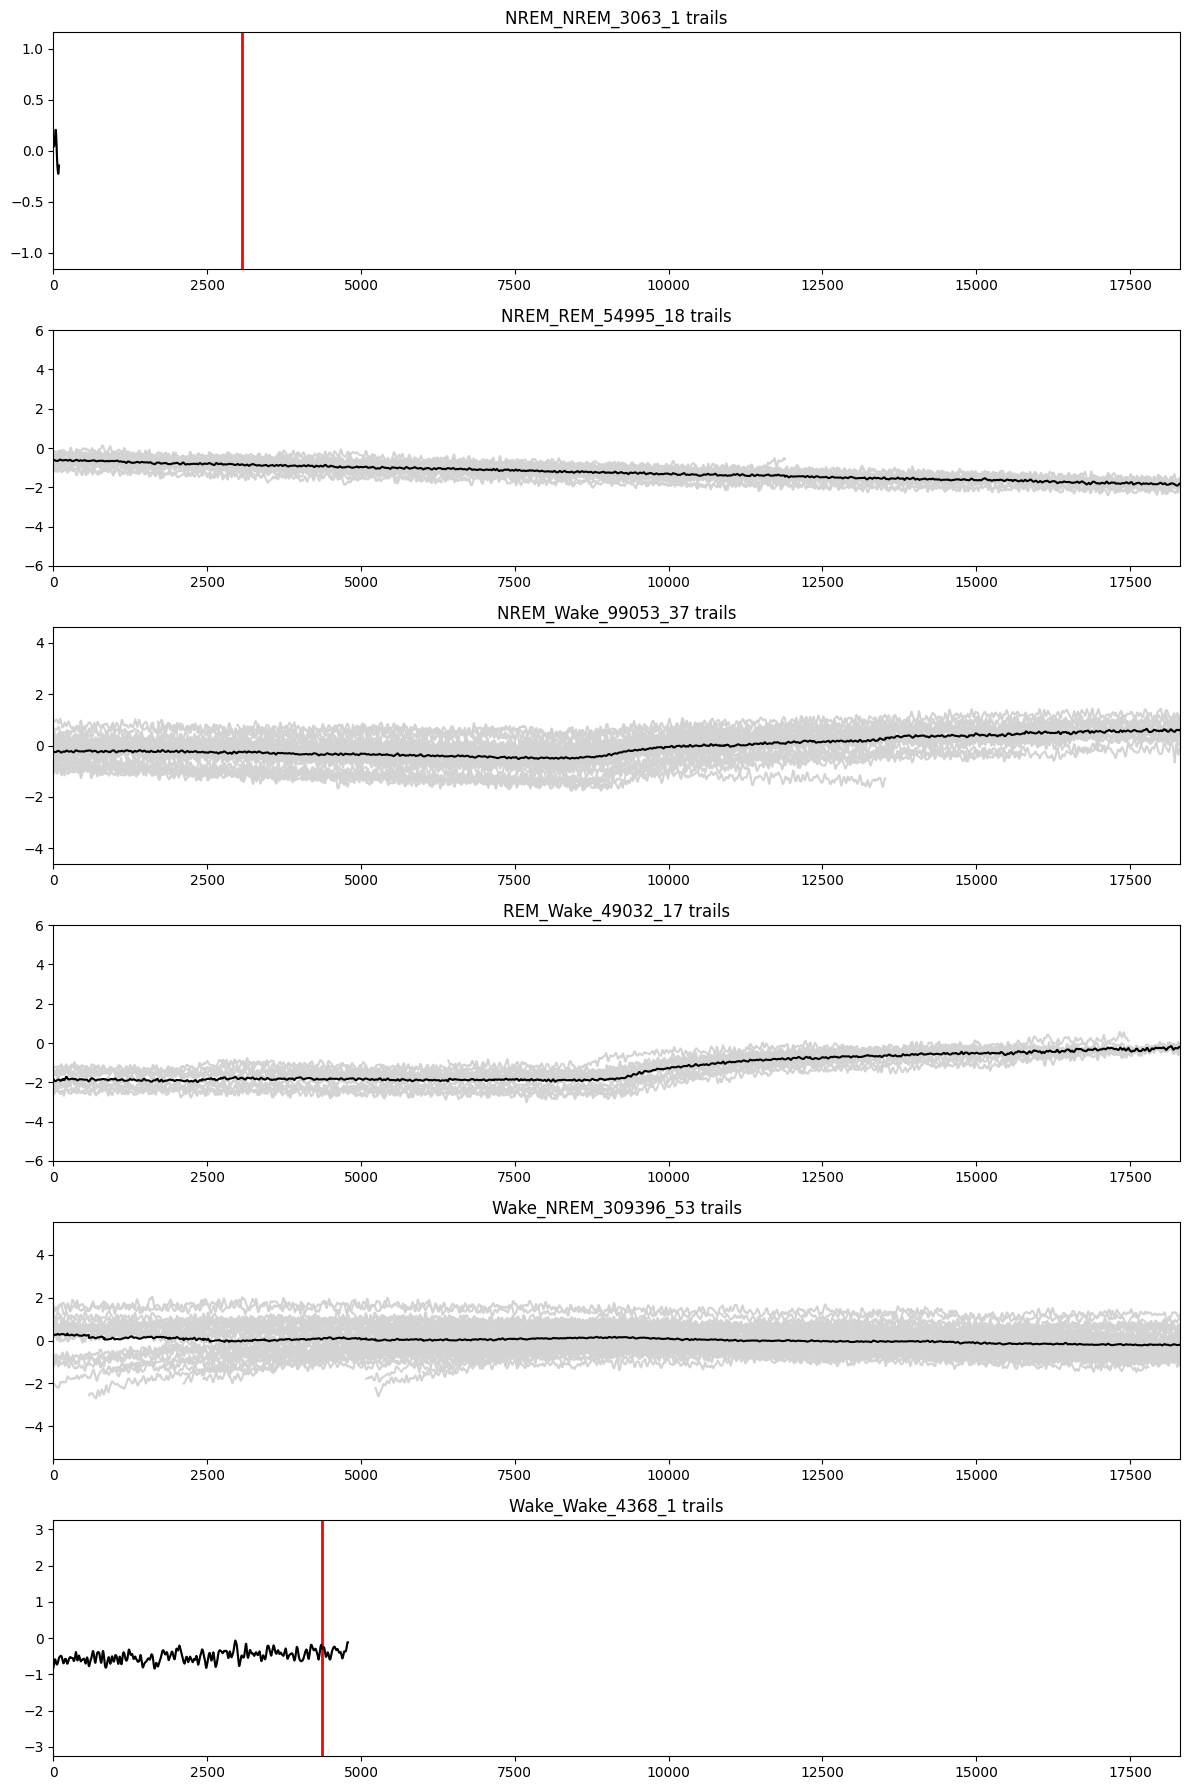

In [33]:
# Get data based on each group of transition time points
channel_midata = data.pick_chs(ch_names=[consider_channel])
channel_data = channel_midata.signals[0]
sf = channel_midata.sf[0]

# Draw
signal_figure = plt.figure(figsize=(12, 3*len(transition_points_group)))
signal_ax = signal_figure.subplots(nrows=len(transition_points_group))
signal_figure.set_tight_layout(True)

group_data = {}
for idx, transition_points in enumerate(transition_points_group):
    _name = transition_points[0][0]
    previous_max_length = max([int(each[2]*sf)-int(each[1]*sf) for each in transition_points])
    later_max_length = max([int(each[3]*sf)-int(each[2]*sf)for each in transition_points])
    _name = f'{_name}_{previous_max_length}'
    _temp_lst = []
    for each in transition_points:
        previous_data = channel_data[int(each[1]*sf): int(each[2]*sf)]
        previous_data_padded = np.pad(previous_data, (previous_max_length - len(previous_data), 0), 'constant', constant_values=np.nan)
        later_data = channel_data[int(each[2]*sf): int(each[3]*sf)]
        later_data_padded = np.pad(later_data, (0, later_max_length - len(later_data)), 'constant', constant_values=np.nan)
        _temp_lst.append(np.concatenate([previous_data_padded, later_data_padded]))

    nan_temp_lst = np.array(_temp_lst)
    zero_temp_lst = np.nan_to_num(nan_temp_lst)

    pd.DataFrame(data=np.array(_temp_lst).T,
        columns=['->'.join([str(_) for _ in each[1:]]) for each in transition_points]
        ).to_csv(f'{save_csv_path}\{_name}.csv', index=False)

    [signal_ax[idx].plot(each[previous_max_length-int(30*sf): previous_max_length+int(30*sf)], color='lightgray') for each in nan_temp_lst]
    signal_ax[idx].axvline(int(30*sf), color='red', linewidth=2)
    signal_ax[idx].set_xlim(0, int(60*sf))
    _max = np.max(np.abs(zero_temp_lst))*2
    signal_ax[idx].set_ylim(-_max, _max)
    signal_ax[idx].set_title(f'{_name}_{len(transition_points)} trails')

    # calculate mean line
    _mean_group_data = np.nanmean(nan_temp_lst, axis=0)
    signal_ax[idx].plot(_mean_group_data[previous_max_length-int(30*sf): previous_max_length+int(30*sf)], color='black')

    # signal_ax[idx].xaxis.set_ticks(
    #     [int(each * sf) for each in range(0, previous_max_length+later_max_length+1, 5)],
    #     np.arange(-previous_max_length, later_max_length+1, 5),
    # )

signal_figure.savefig(save_fig_path, dpi=300)


In [18]:
['->'.join([str(_) for _ in each[1:]]) for each in transition_points]


['34.669->42.075->129.749',
 '129.749->135.156->160.001',
 '255.807->288.525->399.631',
 '548.757->556.281->651.038',
 '695.569->703.12->711.548']

In [18]:
# Get data based on each group of transition time points
channel_midata = data.pick_chs(ch_names=[consider_channel])
channel_data = channel_midata.signals[0]
sf = channel_midata.sf[0]
writer = pd.ExcelWriter(save_excel_path)

signal_figure = plt.figure(figsize=(12, 3*len(transition_points_group)))
signal_ax = signal_figure.subplots(nrows=len(transition_points_group))
signal_figure.set_tight_layout(True)

for idx, group in enumerate(transition_points_group):
    _group_data = []
    _group_name = group[0][0]
    _group_time_points = [each[1] for each in group]
    for transition in _group_time_points:
        # Get data based on each transition time point
        start_time = transition - consider_time
        end_time = transition + consider_time
        _group_data.append(channel_data[int(start_time*sf): int(end_time*sf)])
    # align length of each transition data
    _length = min([len(each) for each in _group_data])
    _group_data = np.array([each[:_length] for each in _group_data])
    for each in _group_data:
        signal_ax[idx].plot(each, color='lightgray')
        signal_ax[idx].axvline(_length/2, color='red', linewidth=2)
        signal_ax[idx].set_xlim(0, _length)
        _max = np.max(np.abs(_group_data))*1.5
        signal_ax[idx].set_ylim(-_max, _max)
        signal_ax[idx].set_title(_group_name)

    # calculate mean line
    _mean_group_data = np.mean(_group_data, axis=0)
    signal_ax[idx].plot(_mean_group_data, color='black')

    signal_ax[idx].xaxis.set_ticks(
        [int(each * sf) for each in range(0, 2*consider_time+1, 1)],
        np.arange(-consider_time, consider_time+1, 1),
    )
        
    _df = pd.DataFrame(data=_group_data.T, columns=_group_time_points)
    _df.to_excel(excel_writer=writer, sheet_name=_group_name, index=False)

signal_figure.savefig(save_fig_path, dpi=300)
writer.close()

signal_figure.show()


IndexError: Zscore channel is not in the signal channels (['EEG', 'EMG_1', 'EMG_2', 'EMG_DIFF', 'REF', 'A405', 'A465', 'd465'])